# SPT Data Processing

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/01_cond_factors/spt_processing.ipynb).

This notebook was developed following the procedure by {cite:t}`Gonzalez1999_ParametrosSPT` for estimating the shear strength parameters from the Standard Penetration Test data ([paper in Spanish](https://www.scg.org.co/wp-content/uploads/2021/08/ESTIMATIVOS-DE-PARAMETROS-DE-RESISTENCIA-CON-SPT-1.pdf)).

## Required modules and global setup for plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit, minimize
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    # run('pip install ipympl', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# Figures setup
# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})


## Funciones

In [2]:
def x_from_y(x_coord, y_coord, target_y):
    for i in range(len(y_coord)):
        if y_coord[i] == target_y:  # if target_y coincides with a node
            if i < len(y_coord) and y_coord[i+1] == y_coord[i]:  # if on a horizontal segment:
                return 0.5 * (x_coord[i] + x_coord[i+1])  # return midpoint in x
            else:
                return x_coord[i]
        elif i > 0 and y_coord[i-1] < target_y < y_coord[i]:
            # Interpolate x-value when the target y-value lies between two points
            x1, x2 = x_coord[i-1], x_coord[i]
            y1, y2 = y_coord[i-1], y_coord[i]
            return x1 + (x2 - x1) * (target_y - y1) / (y2 - y1)
    return None  # Return None if y-value not found within the range

def compute_stresses(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth=None):
    𝛾_w = 9.81  # unit weight of water [kN/m³]
    # Copying arrays
    mat_depths = mat_depths.copy()
    𝛾_moist = 𝛾_moist.copy()
    𝛾_sat = 𝛾_sat.copy()
    # Find an appropiate index for locating the watertable
    if wt_depth in mat_depths:
        idx_wt = mat_depths.index(wt_depth)
    elif wt_depth >= mat_depths[-1] or wt_depth is None:
        wt_depth = mat_depths[-1]
        idx_wt = len(mat_depths) - 1
    else:
        for i in range(len(mat_depths)):
            if wt_depth <= mat_depths[i]:
                idx_wt = i
                break
    # Insert the new value at the appropriate index
    mat_depths.insert(idx_wt, wt_depth)
    𝛾_moist.insert(idx_wt, 𝛾_moist[idx_wt])
    𝛾_sat.insert(idx_wt, 𝛾_sat[idx_wt])
    # Create an unified unit weight vector
    𝛾_s = 𝛾_moist[: idx_wt + 1] + 𝛾_sat[idx_wt + 1 :]
    # Create vector of thicknesses
    mat_depths.insert(0, 0)  # insert zero for the first layer
    thickness = np.diff(mat_depths)  # thickness of each soil layer [m]
    # Create a vector for unit weigth of water (zero above wt, and 𝛾_w below)
    𝛾_w = np.full_like(𝛾_s, 𝛾_w)
    𝛾_w[: idx_wt + 1] = 0
    # Compute vertical stresses and water pressure at boundaries
    𝜎_v = np.insert(np.cumsum(thickness * 𝛾_s), 0, 0)
    p_w = np.insert(np.cumsum(thickness * 𝛾_w), 0, 0)
    𝜎_v_eff = 𝜎_v - p_w
    df['Sigma_eff_(kPa)'] = [
        x_from_y(x_coord=𝜎_v_eff, y_coord=mat_depths, target_y=z)
        for z in df['Profundidad_(m)'].to_numpy()
    ]
    return

def compute_corrected_N(df, perfo_diam, field_test_energy):
    # Stress level correction
    n, 𝜎_ref = 0.5, 95.76  # reference stress level = 1 tsf(short) to kPa
    # df['Cn'] = (𝜎_ref / df['Sigma_eff_(kPa)']) ** n  # Liao y Whitman (1986)
    df['Cn'] = 2 / (1 + df['Sigma_eff_(kPa)']/𝜎_ref)  # Skempton (1986)
    # Correction factor to reach an standard energy level of 60%
    df['n1_E60'] = field_test_energy / 60
    # Correction factor due to the length of the drill rod
    n2 = np.empty_like(df['Profundidad_(m)'], dtype=float)
    depth = df['Profundidad_(m)'].to_numpy()
    n2[depth >= 10] = 1
    n2[depth < 10] = 0.95
    n2[depth < 6] = 0.85
    n2[depth < 4] = 0.75
    df['n2'] = n2
    # Correction factor due to the cassing
    mat_type = np.array([int(d[0]) for d in df['Descripción'].to_list()])
    n3 = np.ones_like(df['Profundidad_(m)'], dtype=float)
    n3[mat_type == 1] = 0.8
    n3[mat_type == 2] = 0.8
    n3[mat_type == 3] = 0.9
    n3[mat_type == 4] = 0.8
    n3[mat_type == 5] = 0.85
    n3[mat_type == 6] = 0.9
    n3[df['Revestimiento_(m)'] < df['Profundidad_(m)']] = 1
    df['n3'] = n3
    # Correction factor due to the hole diameter
    if perfo_diam <= 120:
        df['n4'] = 1
    elif perfo_diam <= 150:
        df['n4'] = 1.05
    elif perfo_diam > 150:
        df['n4'] = 1.15
    # N corrected
    df['N45'] = np.int64(df['N_campo'] * df['Cn'] * df['n2'] * df['n3'] * df['n4'] * field_test_energy / 45)
    df['N55'] = np.int64(df['N_campo'] * df['Cn'] * df['n2'] * df['n3'] * df['n4'] * field_test_energy / 55)
    df['N60'] = np.int64(df['N_campo'] * df['Cn'] * df['n2'] * df['n3'] * df['n4'] * field_test_energy / 60)

def compute_correlations(df, corr_𝜙='f'):
    '''
    Correlations for the friction angle based on the letters accompanying the
    formulas (7) and (8) in Gonzalez (1999)
    '''
    # Equivalent friction angle
    if corr_𝜙 == 'a':  # Peck
        df['𝜙_eq'] = 28.5 + 0.25 * df['N45']
    elif corr_𝜙 == 'b':  # Peck, Hanson & Thornburn
        df['𝜙_eq'] = 26.25 * (2 - np.exp(-1 * df['N45']/62))
    elif corr_𝜙 == 'c':  # Kishida
        df['𝜙_eq'] = 15 + (12.5 * df['N45']) ** 0.5
    elif corr_𝜙 == 'd':  # Schmertmann
        df['𝜙_eq'] = np.arctan((df['N45'] / 43.3)**0.34)
    elif corr_𝜙 == 'e':  # Japan National Railway (JNR)
        df['𝜙_eq'] = 27 + 0.1875 * df['N45']
    elif corr_𝜙 == 'f':  # Japan Road Bureau (JRB)
        df['𝜙_eq'] = 15 + (9.375 * df['N45']) ** 0.5
    # Equivalent shear strength 
    df['𝜏_eq'] = df['Sigma_eff_(kPa)'] * np.tan(np.deg2rad(df['𝜙_eq']))
    # Undrained shear strength based on Schmertmann (1975)
    df['Su_(kPa)'] = df['N60'] / 15 * 95.76
    # Put nan to 'Su_(kPa)' where fines are < 50% or isnan
    df.loc[df['Finos_(%)'] < 50, 'Su_(kPa)'] = np.nan
    df.loc[df['Finos_(%)'].isna(), 'Su_(kPa)'] = np.nan
    # Elasticity modulus
    mat_type = np.array([int(d[0]) for d in df['Descripción'].to_list()])
    elastic_mod = np.ones_like(df['Profundidad_(m)'])
    elastic_mod[mat_type == 1] = (250 * (df['N55'] + 15))[mat_type == 1]
    elastic_mod[mat_type == 2] = (500 * (df['N55'] + 15))[mat_type == 2]
    elastic_mod[mat_type == 3] = (40000 + (df['N55'] * 1050))[mat_type == 3]
    mask_4a = np.logical_and(mat_type == 4, df['N55'] <= 15)
    elastic_mod[mask_4a] = (600 * (df['N55'] + 6))[mask_4a]
    mask_4b = np.logical_and(mat_type == 4, df['N55'] > 15)
    elastic_mod[mask_4b] = (2000 + (600 * (df['N55'] + 6)))[mask_4b]
    elastic_mod[mat_type == 5] = (320 * (df['N55'] + 15))[mat_type == 5]
    elastic_mod[mat_type == 6] = (300 * (df['N55'] + 6))[mat_type == 6]
    df['Es_(kPa)'] = elastic_mod


def complete_table(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth=None, perfo_diam=75,
                   field_test_energy=60, corr_𝜙='f'):
    compute_stresses(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth)
    compute_corrected_N(df, perfo_diam, field_test_energy)
    compute_correlations(df, corr_𝜙='f')

def f_mc(x, m, b):  # Linear function for Mohr-Coulomb envelope with non-zero intercept
    return m * x + b

def f_mc_b0(x, m):  # Linear function for Mohr-Coulomb envelope with zero intercept forced if negative
    return m * x


palette = mpl.colors.ListedColormap(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
palette = mpl.colors.ListedColormap(['#004488', '#DDAA33', '#BB5566', '#6699CC', '#EECC66', '#EE99AA'])


def plot_processing(df, mat_depths, wt_depth, plot_su=True, figsize=None):
    if figsize is None:
        figsize = [9, 6]
    fig, axs = plt.subplot_mosaic([['A', 'B', 'B'], ['A', '.', '.']],
                              layout='constrained', figsize=figsize)
    # Set Dark2 as the default color cycle
    # plt.style.use('seaborn-darkgrid')
    plt.rcParams.update({'axes.prop_cycle': plt.cycler(color=palette.colors)})

    # Create a twin axis for Su in axs['A'] if plot_su is True
    if plot_su:
        ax_twin = axs['B'].twinx()

    # Plotting the fine fraction content
    if 'Finos_(%)' in df.columns:
        if not df['Finos_(%)'].isna().all():  # check if it's not full of nan
            axs['A'].plot(df['Finos_(%)'], df['Profundidad_(m)'], ls="",
                        marker="|", mfc="w", mec="k", ms=10, mew=2.5, label="Fine fraction [%]")
    for i, mat in enumerate(df['Material'].unique()):
        df_mat = df[df['Material'] == mat]
        # Plotting N values vs depth
        axs['A'].plot(df_mat['N_campo'], df_mat['Profundidad_(m)'], ls="", marker="o", ms=6,
                      mfc=mpl.colors.to_rgba(f"C{i}", 0.8), mec=mpl.colors.to_rgba('k', 1), mew=.75)#, label=mat)
        # Plotting shear strength vs sigma_v
        axs['B'].plot(df_mat['Sigma_eff_(kPa)'], df_mat['𝜏_eq'], ls="", marker="o", ms=6,
                      mfc=mpl.colors.to_rgba(f"C{i}", 0.8), mec=mpl.colors.to_rgba('k', 1), mew=.75, label=mat)
        if len(df_mat) == 1:
            phi = df_mat['𝜙_eq'].values[0]
            m, b = np.tan(np.deg2rad(phi)), 0.0
            axs['B'].plot(df_mat['Sigma_eff_(kPa)'], m * df_mat['Sigma_eff_(kPa)'] + b,
                        ls=':', c=f"C{i}", label=f"$\\phi'={phi:.1f}^\\circ$")
        else:
            m, b = curve_fit(f_mc, df_mat['Sigma_eff_(kPa)'], df_mat['𝜏_eq'])[0]
            if b < 0:
                m, b = curve_fit(f_mc_b0, df_mat['Sigma_eff_(kPa)'], df_mat['𝜏_eq'])[0][0], 0.0
            phi = np.rad2deg(m)
            axs['B'].plot(df_mat['Sigma_eff_(kPa)'], m * df_mat['Sigma_eff_(kPa)'] + b,
                        ls=':', c=f"C{i}", label=f"$\\phi'={phi:.1f}^\\circ$, $c'={b:.1f}$ kPa")
        # Plotting Su values vs depth in a twin axis if plot_su is True
        if plot_su and not np.isnan(df_mat['Su_(kPa)'].mean()):
            label = f"Average $S_\\mathrm{{u}} = {df_mat['Su_(kPa)'].mean():.1f}$ kPa"
            ax_twin.plot(df_mat['Sigma_eff_(kPa)'], df_mat['Su_(kPa)'], ls="", marker="_", ms=7,
                         mec=mpl.colors.to_rgba(f"C{i}", 1), mew=2.5)#, label=label)
            # Fake plot in the original axis to show the legend
            axs['B'].plot([], [], ls="", marker="_", ms=7, mec=mpl.colors.to_rgba(f"C{i}", 1),
                          mew=2.5, label=label)
    for d in mat_depths:
        axs['A'].axhline(d, color="k", ls="--", lw=1.25)
    axs['A'].axhline(0, color="g", ls="-", lw=3.0, label="Terrain surface")
    axs['A'].axhline(np.nan, color="k", ls="--", lw=1.25, label="Material boundary")
    axs['A'].axhline(y=wt_depth, ls="-", color="XKCD:electric blue", lw=1.25, label="Watertable")

    # Plot setup
    axs['A'].invert_yaxis()
    # invert y-axis for depth for the twin axis
    if plot_su:
        ax_twin.set_ylabel("$S_\\mathrm{u}$  [kPa]")
        ax_twin.spines["right"].set_linewidth(1.5)
    axs['A'].set(xlabel="N$_\\mathrm{SPT}$ &  Fine fraction [%]", ylabel="Depth [m]", xlim=[-5, 105])
    axs['B'].set(xlabel="$\\sigma'$  [kPa]", ylabel="$\\tau'$  [kPa]")
    for ax in axs.values():
        ax.xaxis.set_label_position("top")
        ax.xaxis.tick_top()
        ax.spines["top"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.grid(True, ls="--", color="silver")
    # axs['A'].legend(loc="upper right")
    fig.legend(loc='upper center', bbox_to_anchor=(0.7, 0.45), ncol=1, handlelength=2.5)
    # Manual legend for plot A 
    handles = [mpl.lines.Line2D([0], [0], marker="o", mec="k", mfc="0.5", ms=6, lw=0, label="N$_\\mathrm{SPT}$"),
               mpl.lines.Line2D([0], [0], marker="|", mec="k", ms=10, mew=2.5, lw=0, label="Fine\nfraction")]
    axs['A'].legend(handles=handles, loc="upper right", fontsize="small")
    # Manual legend for plot B
    handles = [mpl.lines.Line2D([0], [0], marker="o", mec="k", mfc="0.5", ms=6, ls=':', label="$\\phi'-c'$ correlation"),
               mpl.lines.Line2D([0], [0], marker="_", mec="k", ms=7, mew=2.5, lw=0, label=f"$S_\\mathrm{{u}}$ correlation")]
    axs['B'].legend(handles=handles, loc="upper left", fontsize="small", handlelength=2.5)
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return

## Example

### Reading the input data

In [3]:
testing_data = True  # Set to False to use the GUI to load the data from an external file

In [4]:
# Non-tabulated data
mat_depths = [7, 12.5, 18]  # bottom depth of each material [m]
𝛾_moist = [18.50, 16.5, 16.00]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
𝛾_sat = [19.50, 17.0, 17.50]  # Saturated unit weight of each soil layer [kN/m³]
wt_depth = 10  # watertable depth [m]
perfo_diam = 75  # [mm]
field_test_energy = 45  # [%]
corr_𝜙 = 'f'  # JRB


In [6]:
# Tabulated data
if testing_data:
    url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/spt/"
    df = pd.read_excel(f"{url}spt_processing_input_2.xlsx")
elif testing_data is False and 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:  # GUI for file selection from local machine if not in CoLab
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)

# # df.loc[4, 'Finos_(%)'] = 55
df

/home/eamontoyaa/.pyenv/versions/3.11.11/envs/EAFIT-3p11-env/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,Material,Descripción,Profundidad_(m),Revestimiento_(m),N_campo,Finos_(%)
0,Dep. de vertiente,"6 - Limos, suelos finogranulares",0.25,0,4,NaN
1,Dep. de vertiente,"6 - Limos, suelos finogranulares",1.25,0,12,18.0
2,Dep. de vertiente,"6 - Limos, suelos finogranulares",2.25,0,11,35.0
3,Dep. de vertiente,"6 - Limos, suelos finogranulares",4.25,0,9,NaN
4,Dep. de vertiente,"6 - Limos, suelos finogranulares",5.25,0,12,23.0
5,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,7.25,6,12,5.0
6,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,8.25,6,23,NaN
7,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,10.25,6,19,0.0
8,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,11.25,6,16,1.0
9,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,12.25,6,33,10.0


### Processing the data and completing the table

In [7]:
complete_table(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth, perfo_diam, field_test_energy, corr_𝜙)
df

,Material,Descripción,Profundidad_(m),Revestimiento_(m),N_campo,Finos_(%),Sigma_eff_(kPa),Cn,n1_E60,n2,n3,n4,N45,N55,N60,𝜙_eq,𝜏_eq,Su_(kPa),Es_(kPa)
0,Dep. de vertiente,"6 - Limos, suelos finogranulares",0.25,0,4,NaN,4.6250,1.907855,0.75,0.75,1.0,1,5,4,4,21.846532,1.854226,NaN,3000.0
1,Dep. de vertiente,"6 - Limos, suelos finogranulares",1.25,0,12,18.0,23.1250,1.610969,0.75,0.75,1.0,1,14,11,10,26.456439,11.507756,NaN,5100.0
2,Dep. de vertiente,"6 - Limos, suelos finogranulares",2.25,0,11,35.0,41.6250,1.394039,0.75,0.75,1.0,1,11,9,8,25.155048,19.547364,NaN,4500.0
3,Dep. de vertiente,"6 - Limos, suelos finogranulares",4.25,0,9,NaN,78.6250,1.098260,0.75,0.85,1.0,1,8,6,6,23.660254,34.448930,NaN,3600.0
4,Dep. de vertiente,"6 - Limos, suelos finogranulares",5.25,0,12,23.0,97.1250,0.992923,0.75,0.85,1.0,1,10,8,7,24.682458,44.636487,NaN,4200.0
5,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,7.25,6,12,5.0,133.6250,0.834928,0.75,0.95,1.0,1,9,7,7,24.185587,60.013056,NaN,7040.0
6,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,8.25,6,23,NaN,150.1250,0.778901,0.75,0.95,1.0,1,17,13,12,27.624381,78.564814,NaN,8960.0
7,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,10.25,6,19,0.0,180.7975,0.692514,0.75,1.00,1.0,1,13,10,9,26.039701,88.335964,NaN,8000.0
8,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,11.25,6,16,1.0,187.9875,0.674966,0.75,1.00,1.0,1,10,8,8,24.682458,86.394869,NaN,7360.0
9,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,12.25,6,33,10.0,195.1775,0.658286,0.75,1.00,1.0,1,21,17,16,29.031215,108.327703,NaN,10240.0


## Plotting the processed data

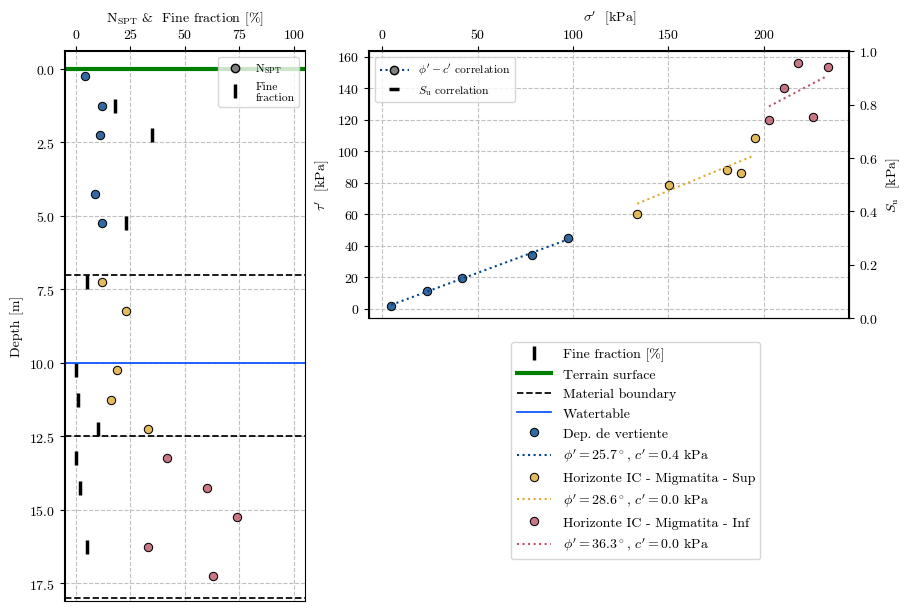

In [8]:
plot_processing(df, mat_depths, wt_depth)